In [20]:
# Imports
import torch
import torch.nn as nn
from torchvision import models, transforms
from torchvision.models import MobileNet_V2_Weights
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

import os

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import datasets

import numpy as np

import matplotlib.pyplot as plt

In [21]:
# Variables
BATCH_SIZE = 32
RANDOM_STATE = 42
TEST_SIZE = 0.2

TRAIN_DIR = '../prep/preprocessed_images/train'
TEST_DIR = '../prep/preprocessed_images/test'

EPOCHS = 10

STEP_SIZE = 5  
GAMMA = 0.1
lr = 0.001

In [22]:
# Define k fold cross validation
K_FOLDS = 5

metrics = {
    'validation loss': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

best_metrics = {
    'validation loss': [0] * K_FOLDS,
    'accuracy': [0] * K_FOLDS,
    'precision': [0] * K_FOLDS,
    'recall': [0] * K_FOLDS,
    'f1': [0] * K_FOLDS
}

kf = StratifiedKFold(n_splits=K_FOLDS, random_state=RANDOM_STATE, shuffle=True)

In [23]:
# Set device: use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
# Load pre-trained MobileNetV2
model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

In [25]:
# Freeze the convolutional layers (feature extraction part)
for param in model.parameters():
    param.requires_grad = False

In [26]:
# Modify the classifier part to suit the task (3 classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)  # 3 classes: rock, paper, scissors

In [27]:
# Move the model to the GPU (if available)
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [28]:
# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler
optimizer = Adam(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)


In [29]:
# Early stopping parameters
patience = 3
best_val_loss = float('inf')
best_model_wts = None

best_overall_val_loss = float('inf')
best_model_wts_overall = None
best_overal_epoch_for_fold = -1
best_fold = -1

patience_counter = 0
epoch_counter = 0

In [30]:
# Define a transformation for the images
transform = transforms.Compose([
    transforms.ToTensor()
])

In [31]:
# Load the training dataset
full_training_dataset = ImageFolder(root=TRAIN_DIR, transform=transform)  # No need for separate folders

In [32]:
# Extract only the labels from the dataset
targets = [full_training_dataset.targets[i] for i in range(len(full_training_dataset))]

# Define the stratified split
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Obtain train and validation indices
for train_idx, val_idx in stratified_split.split(np.zeros(len(targets)), targets):
    train_set = Subset(full_training_dataset, train_idx)
    val_set = Subset(full_training_dataset, val_idx)


In [33]:
# Load all the data
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(ImageFolder(root=TEST_DIR, transform=transform), batch_size=BATCH_SIZE, shuffle=False)

print('Training set size:', len(train_set))
print('Validation set size:', len(val_set))
print('Test set size:', len(test_loader.dataset))

Training set size: 414
Validation set size: 104
Test set size: 133


In [34]:
# Training loop
for fold, (train_idx, val_idx) in enumerate(kf.split(train_set, [train_set[i][1] for i in range(len(train_set))])):
    print(f"\nFold {fold + 1}/{K_FOLDS}")

    patience_counter = 0 # Reset patience counter for each fold
    epoch_counter = 0 # Reset epoch counter for each fold

    best_val_loss = float('inf') # Reset best validation loss for each fold
    best_model_wts = None # Reset best model weights for each fold

    # Prepare data for this fold
    train_subset = Subset(train_set, train_idx)
    val_subset = Subset(train_set, val_idx)

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

    # Reset the model and optimizer for each fold
    model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
    model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

    criterion = nn.CrossEntropyLoss()

    while True:
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for images, label in train_loader:
            images, labels = images.to(device), label.to(device)

            optimizer.zero_grad()  # Zero the gradients
            output = model(images)
            loss = criterion(output, label)
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the weights

            running_loss += loss.item() * images.size(0)
            _, predicted = output.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Update the scheduler after the optimizer step
        scheduler.step()

        train_loss = running_loss / len(train_set)
        train_accuracy = 100. * correct / total
        print(f'Epoch {epoch_counter + 1}')
        print(f'Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():  # Disable gradient calculation for validation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                output = model(images)
                loss = criterion(output, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = output.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_set)
        val_accuracy = 100. * correct / total
        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

        # Calculate metrics: precision, recall, f1 score
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

        print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

        # Store the metrics
        metrics['accuracy'].append(val_accuracy)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['f1'].append(f1)

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()
            best_epoch = epoch_counter
            patience_counter = 0

            # store the metrics and overwrite the old metrics
            best_metrics['accuracy'][fold] = val_accuracy
            best_metrics['precision'][fold] = precision
            best_metrics['recall'][fold] = recall
            best_metrics['f1'][fold] = f1
        else:
            patience_counter += 1  # Increase the patience counter
            print(f'No improvement detected. Patience counter: {patience_counter}/{patience}')

        # Check if patience has run out
        if patience_counter >= patience:
            print(f'\nEarly stopping triggered at epoch {epoch_counter + 1}')
            break # Stop the training loop

        epoch_counter += 1
    
    # Store the best model from this fold if its validation loss is the best so far
    if best_val_loss < best_overall_val_loss:
        print(f"\nNew best model from fold {fold + 1} with validation loss: {best_val_loss:.4f}")

        best_overall_val_loss = best_val_loss
        best_model_wts_overall = best_model_wts
        best_fold = fold
        best_overal_epoch_for_fold = best_epoch

    # Load the best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
        print(f'\nRestored model from epoch {best_epoch + 1} with validation loss: {best_val_loss:.4f}')
    
    print(f"\nFold {fold + 1} completed.")

# Load the best model weights from all the folds
if best_model_wts_overall is not None:
    model.load_state_dict(best_model_wts_overall)
    print(f"\nBest model from fold {best_fold + 1} with validation loss: {best_overall_val_loss:.4f} loaded.")




Fold 1/5
Epoch 1
Loss: 2.0738, Accuracy: 67.07%
Validation Loss: 0.3566, Accuracy: 92.77%
Precision: 0.9498, Recall: 0.9277, F1: 0.9339
Epoch 2
Loss: 0.0798, Accuracy: 97.28%
Validation Loss: 0.3387, Accuracy: 96.39%
Precision: 0.9657, Recall: 0.9639, F1: 0.9632
Epoch 3
Loss: 0.0448, Accuracy: 99.09%
Validation Loss: 0.1742, Accuracy: 96.39%
Precision: 0.9669, Recall: 0.9639, F1: 0.9635
Epoch 4
Loss: 0.0436, Accuracy: 99.40%
Validation Loss: 0.0045, Accuracy: 100.00%
Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Epoch 5
Loss: 0.0699, Accuracy: 98.49%
Validation Loss: 0.0205, Accuracy: 98.80%
Precision: 0.9883, Recall: 0.9880, F1: 0.9879
No improvement detected. Patience counter: 1/3
Epoch 6
Loss: 0.0031, Accuracy: 100.00%
Validation Loss: 0.0150, Accuracy: 98.80%
Precision: 0.9884, Recall: 0.9880, F1: 0.9880
No improvement detected. Patience counter: 2/3
Epoch 7
Loss: 0.0049, Accuracy: 100.00%
Validation Loss: 0.0229, Accuracy: 98.80%
Precision: 0.9884, Recall: 0.9880, F1: 0.9880
No i

In [35]:
# Print best model metrics
print("\nBest Model Metrics:")
print(f"Validation Loss: {best_metrics['validation loss'][best_fold]:.4f}")
print(f"Accuracy: {best_metrics['accuracy'][best_fold]:.4f}")
print(f"Precision: {best_metrics['precision'][best_fold]:.4f}")
print(f"Recall: {best_metrics['recall'][best_fold]:.4f}")
print(f"F1 Score: {best_metrics['f1'][best_fold]:.4f}")

# Print all metrics for all folds
print("\nAll Metrics:")
for i in range(K_FOLDS):
    print(f"\nFold {i + 1} Metrics:")
    print(f"Validation Loss: {best_metrics['validation loss'][i]:.4f}")
    print(f"Accuracy: {best_metrics['accuracy'][i]:.4f}")
    print(f"Precision: {best_metrics['precision'][i]:.4f}")
    print(f"Recall: {best_metrics['recall'][i]:.4f}")
    print(f"F1 Score: {best_metrics['f1'][i]:.4f}")


Best Model Metrics:
Validation Loss: 0.0000
Accuracy: 100.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

All Metrics:

Fold 1 Metrics:
Validation Loss: 0.0000
Accuracy: 100.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Fold 2 Metrics:
Validation Loss: 0.0000
Accuracy: 100.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Fold 3 Metrics:
Validation Loss: 0.0000
Accuracy: 100.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Fold 4 Metrics:
Validation Loss: 0.0000
Accuracy: 100.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Fold 5 Metrics:
Validation Loss: 0.0000
Accuracy: 100.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [36]:
# Test loop
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader.dataset)
test_accuracy = 100. * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Classification report
print('\nClassification Report:')
print(classification_report(all_labels, all_preds))

# Confusion matrix
print('\nConfusion Matrix:')
print(confusion_matrix(all_labels, all_preds))


Test Loss: 0.0060, Test Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        54
           2       1.00      1.00      1.00        39

    accuracy                           1.00       133
   macro avg       1.00      1.00      1.00       133
weighted avg       1.00      1.00      1.00       133


Confusion Matrix:
[[40  0  0]
 [ 0 54  0]
 [ 0  0 39]]


In [37]:
# Save the model
torch.save(model, './model/model.pth')

In [53]:
def visualize_feature_maps(model, layer_names, input_image):
    activations = {}

    def hook_fn(module, input, output):
        layer_name = list(model.features._modules.keys())[list(model.features._modules.values()).index(module)]
        activations[layer_name] = output

    hooks = []
    for layer_name in layer_names:
        layer = model.features._modules[layer_name]
        hooks.append(layer.register_forward_hook(hook_fn))

    model.eval()
    with torch.no_grad():
        _ = model(input_image)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Plot the feature maps
    for layer_name, activation in activations.items():
        num_feature_maps = activation.shape[1]
        fig, axes = plt.subplots(1, num_feature_maps, figsize=(num_feature_maps * 2, 2))
        for i in range(num_feature_maps):
            ax = axes[i]
            ax.imshow(activation[0, i].cpu().numpy(), cmap='viridis')
            ax.axis('off')
        plt.suptitle(f'Feature maps from layer: {layer_name}')
        plt.show()


In [54]:
def get_random_image_from_loader(loader):
    # Function to get a random image from the loader
    data_iter = iter(loader)
    images, labels = next(data_iter)
    return images[0], labels[0]

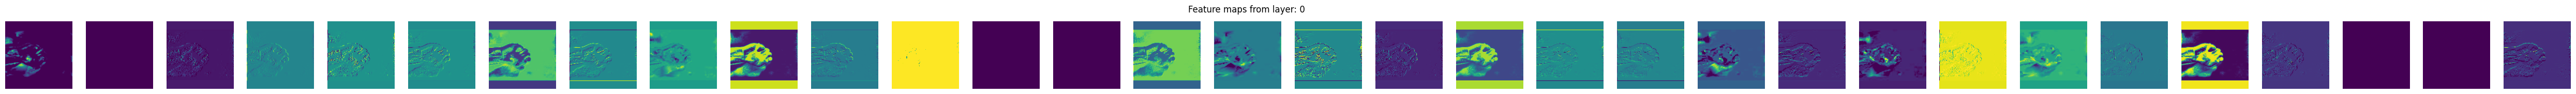

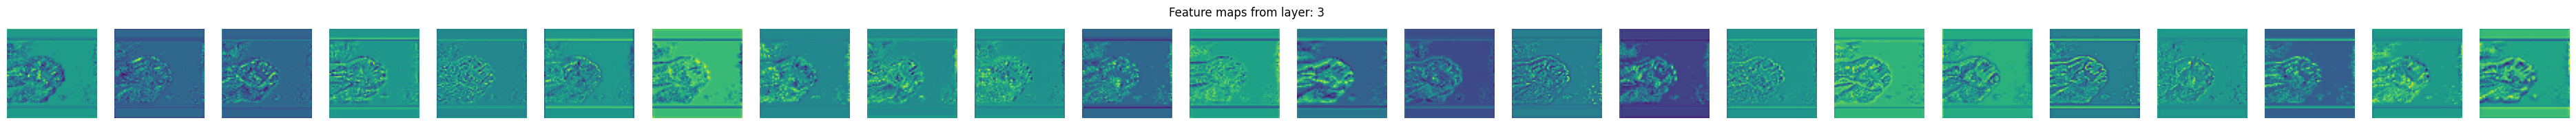

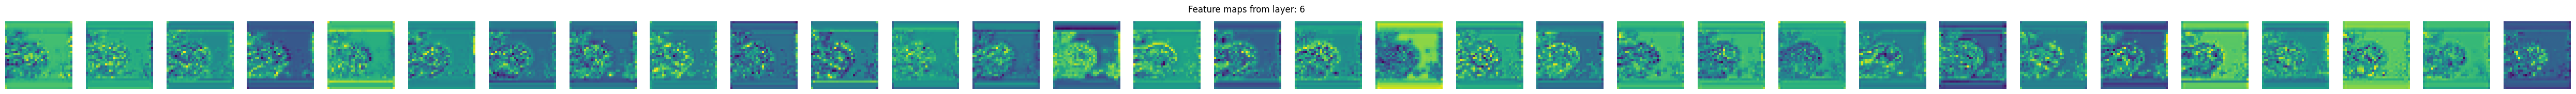

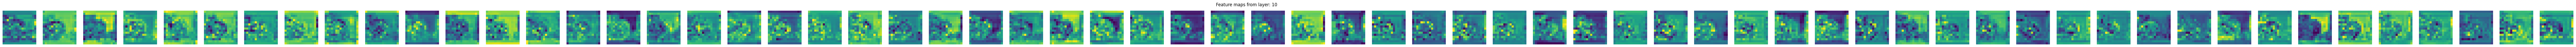

In [ ]:
random_image, random_label = get_random_image_from_loader(train_loader)
random_image_batch = random_image.unsqueeze(0)  # Add batch dimension

# Update layer names based on the model architecture
layer_names = ["0", "3", "6", "10", "15"]

visualize_feature_maps(model, layer_names, random_image_batch)

print(f"Visualizing feature maps for label: {random_label.item()}")